In [127]:
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datatypes import convert_to
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.annotation.ggs import GreedyGaussianSegmentation
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import os

%run "1.03-vr-data-loading.ipynb" # makes the load_datasets function available


In [128]:
from typing import Dict, Optional, List, Tuple, Any
import datetime


def check_data_validity(X):
    # Check for NaN values
    if X.isna().any().any():
        print("Warning: Data contains NaN values")
        X = X.fillna(method='ffill').fillna(method='bfill')
    
    # Check for constant columns
    constant_cols = [col for col in X.columns if X[col].nunique() == 1]
    if constant_cols:
        print(f"Warning: Constant columns found: {constant_cols}")
        X = X.drop(columns=constant_cols)
    
    # Check for perfect correlations
    corr_matrix = X.corr()
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i,j]) > 0.99:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))
    if high_corr_pairs:
        print(f"Warning: Highly correlated features found: {high_corr_pairs}")
    
    # Add small noise if needed
    if len(X.columns) > 1:  # Only if more than one feature
        X = X + np.random.normal(0, 1e-6, X.shape)
    
    return X

def greedy_gaussian_segmentation(
        dataframesByPatient: Dict[str, List[pd.DataFrame]], 
        supervised: bool = False, 
        label_column: Optional[str] = None, 
        k_max: int = 10, 
        time_column: Optional[str] = None,
        num_days: Optional[int] = None
        ) -> Dict[str, Dict[str, Any]]:
    """
    Perform greedy Gaussian segmentation individually on each dataset.
    
    Parameters:
    -----------
    dataframesByPatient: Dict[str, List[pd.DataFrame]]
        Dictionary containing patient IDs as keys and lists of their dataframes as values
    supervised: bool
        Whether to use supervised learning (with provided labels)
    label_column: Optional[str]
        Name of the column containing segmentation labels
    k_max: int
        Maximum number of segments for the GGS algorithm
    time_column: Optional[str]
        Name of the column containing timestamps
    num_days: Optional[int]
        Number of days to use for training and prediction. If None, use all days.
        
    Returns:
    --------
    Dict[str, Dict[str, Any]]
        Results dictionary containing segmentation results for each patient and dataset
    """
    results = {}
    
    for patient_id, dataframes in dataframesByPatient.items():
        results[patient_id] = {}
        
        for i, df in enumerate(dataframes):
            # Prepare X
            X = df.drop(columns=[col for col in df.columns 
                               if 'msg_type' in col 
                               or 'patient_id' in col 
                               or col == label_column 
                               or col == time_column])
            
            X = check_data_validity(X)
            
            # Select a random subset of consecutive days if num_days is specified
            if num_days is not None:
                if time_column:
                    # Convert to datetime if not already
                    if not pd.api.types.is_datetime64_any_dtype(df[time_column]):
                        df[time_column] = pd.to_datetime(df[time_column])
                    # Get unique days by normalizing to midnight
                    unique_days = df[time_column].dt.normalize().unique()
                else:
                    # Convert index to datetime if not already
                    if not pd.api.types.is_datetime64_any_dtype(df.index):
                        df.index = pd.to_datetime(df.index)
                    unique_days = df.index.normalize().unique()
                
                if len(unique_days) > num_days:
                    start_idx = np.random.randint(0, len(unique_days) - num_days + 1)
                    selected_days = unique_days[start_idx:start_idx + num_days]
                    if time_column:
                        mask = df[time_column].dt.normalize().isin(selected_days)
                        X = X[mask]
                        if label_column:
                            y = df[label_column][mask]
                    else:
                        mask = df.index.normalize().isin(selected_days)
                        X = X[mask]
                        if label_column:
                            y = df[label_column][mask]

            # Initialize segmenter for this dataset
            segmenter = GreedyGaussianSegmentation(k_max=k_max, verbose=True)
            
            # Fit the model
            print(f"Training model for Patient {patient_id}, Dataset number {i}...")
            if supervised and label_column:
                segmenter.fit(X, y)
            else:
                segmenter.fit(X)
            
            # Predict segmentation
            print(X.shape)
            print(X.columns)
            segmentation = segmenter.predict(X)
            
            # Store results
            results[patient_id][f'dataset_{i}'] = {
                'data': df,
                'X': X,
                'segmentation': segmentation,
                'actual_labels': y if label_column else None
            }
            
            # Visualize results
            # print(f"\nVisualizing results for Patient {patient_id}, Dataset {i}")
            # visualize_segmentation(
            #     X, 
            #     segmentation, 
            #     actual_labels=df[label_column] if label_column else None,
            #     column_name='bgl'
            # )
            # plt.show()
    
    return results


In [129]:
def visualize_segmentation(
    X_nested: pd.DataFrame, 
    segmentation: np.ndarray, 
    actual_labels: Optional[np.ndarray] = None, 
    column_name: str = 'bgl'
) -> None:
    """
    Visualize the segmented time series data.
    
    Parameters:
    X_nested (pd.DataFrame): The time series data.
    segmentation (np.ndarray): Array of shape (n_samples,) where each entry indicates the segment number.
    actual_labels (Optional[np.ndarray]): Array of actual labels, if available.
    column_name (str): The name of the column to plot.
    
    Returns:
    None: This function plots the visualization but does not return any value.
    """
    plt.figure(figsize=(15, 8))
    
    # Plot the time series with predicted segmentation
    plt.subplot(2, 1, 1)
    plt.plot(X_nested.index, X_nested[column_name].values, label=column_name)
    
    unique_segments = np.unique(segmentation)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))
    
    for segment, color in zip(unique_segments, colors):
        mask = segmentation == segment
        plt.axvspan(X_nested.index[mask].min(), X_nested.index[mask].max(), 
                    alpha=0.2, color=color, label=f'Predicted Segment {segment}')
    
    plt.title(f'{column_name} Over Time with Predicted Segmentation')
    plt.xlabel('Time')
    plt.ylabel(column_name)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Plot the time series with actual labels if provided
    if actual_labels is not None:
        plt.subplot(2, 1, 2)
        plt.plot(X_nested.index, X_nested[column_name].values, label=column_name)
        
        unique_labels = np.unique(actual_labels)
        label_colors = plt.cm.Set2(np.linspace(0, 1, len(unique_labels)))
        
        for label, color in zip(unique_labels, label_colors):
            mask = actual_labels == label
            plt.axvspan(X_nested.index[mask].min(), X_nested.index[mask].max(), 
                        alpha=0.2, color=color, hatch='///', label=f'Actual Label {label}')
        
        plt.title(f'{column_name} Over Time with Actual Labels')
        plt.xlabel('Time')
        plt.ylabel(column_name)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
    
    plt.show()

# Version 2: Supervised
This version is supervised. That is, it is trained to segment the data in a particular way.
The meal annotation plus 2 hours dataset is used. The standard GGS algorithm is applied to the entire dataset (individually to each patient's data)
The goal of this model is to segment the data around meal times.


In [130]:
datasets_by_patient = load_datasets()
datasets_by_patient = create_segmentation_labels(datasets_by_patient)
datasets_by_patient = preprocess_datasets(datasets_by_patient)

results = greedy_gaussian_segmentation(
    datasets_by_patient, 
    supervised=True, 
    label_column='segmentation_label', 
    k_max=10,
    num_days=2
)


C:\Users\viloh\AppData\Local\Temp\ipykernel_15576\3776252448.py:131: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\viloh\AppData\Local\Temp\ipykernel_15576\3776252448.py:131: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\viloh\AppData\Local\Temp\ipykernel_15576\3776252448.py:131: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\viloh\AppData\Local\Temp\ipykernel_15576\377625244

Training model for Patient 500030, Dataset number 0...
(576, 4)
Index(['bgl', 'dose_units', 'food_g', 'food_glycemic_index'], dtype='object')
Training model for Patient 500030, Dataset number 1...
(576, 4)
Index(['bgl', 'dose_units', 'food_g', 'food_glycemic_index'], dtype='object')
Training model for Patient 500030, Dataset number 2...
(576, 4)
Index(['bgl', 'dose_units', 'food_g', 'food_glycemic_index'], dtype='object')
Training model for Patient 500030, Dataset number 3...
(576, 4)
Index(['bgl', 'dose_units', 'food_g', 'food_glycemic_index'], dtype='object')
Training model for Patient 500030, Dataset number 4...
(576, 4)
Index(['bgl', 'dose_units', 'food_g', 'food_glycemic_index'], dtype='object')
Training model for Patient 500030, Dataset number 5...
(576, 4)
Index(['bgl', 'dose_units', 'food_g', 'food_glycemic_index'], dtype='object')
Training model for Patient 679372, Dataset number 0...
(576, 4)
Index(['bgl', 'dose_units', 'food_g', 'food_glycemic_index'], dtype='object')
Traini

In [131]:
print(results['500030']['dataset_1']['segmentation'])

[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6

Visualizing results for Patient 500030, dataset_0


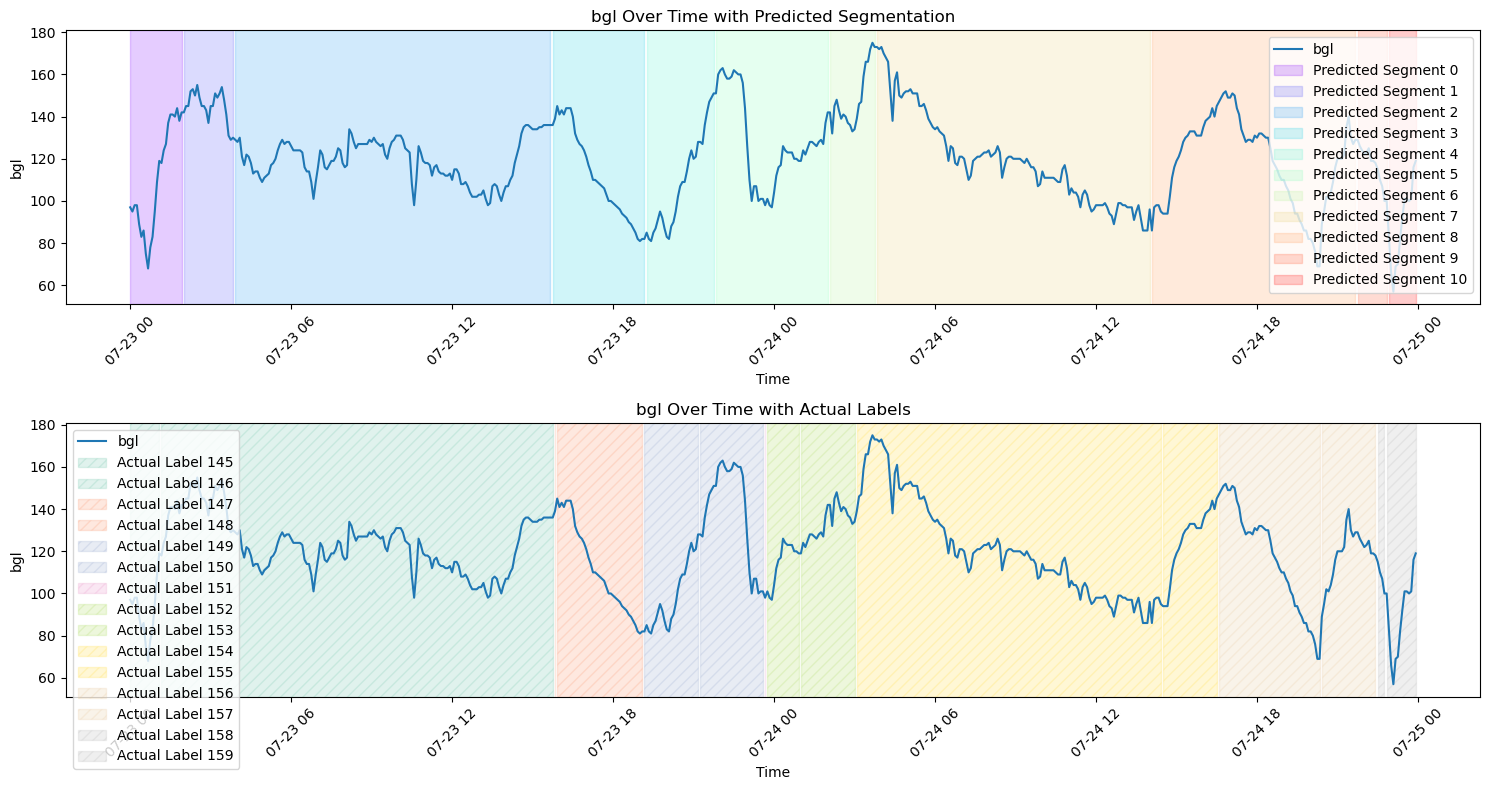

Visualizing results for Patient 500030, dataset_1


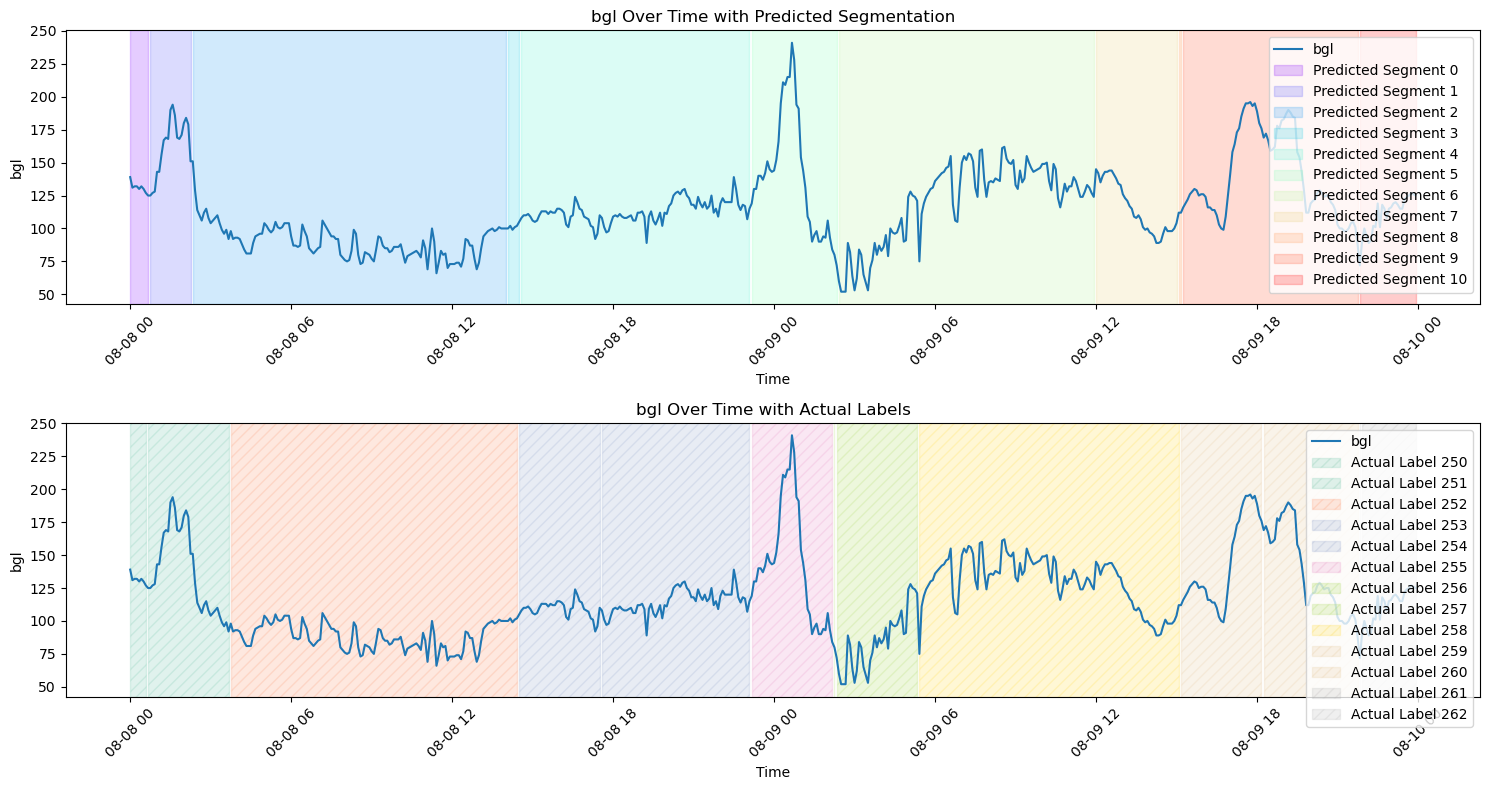

Visualizing results for Patient 500030, dataset_2


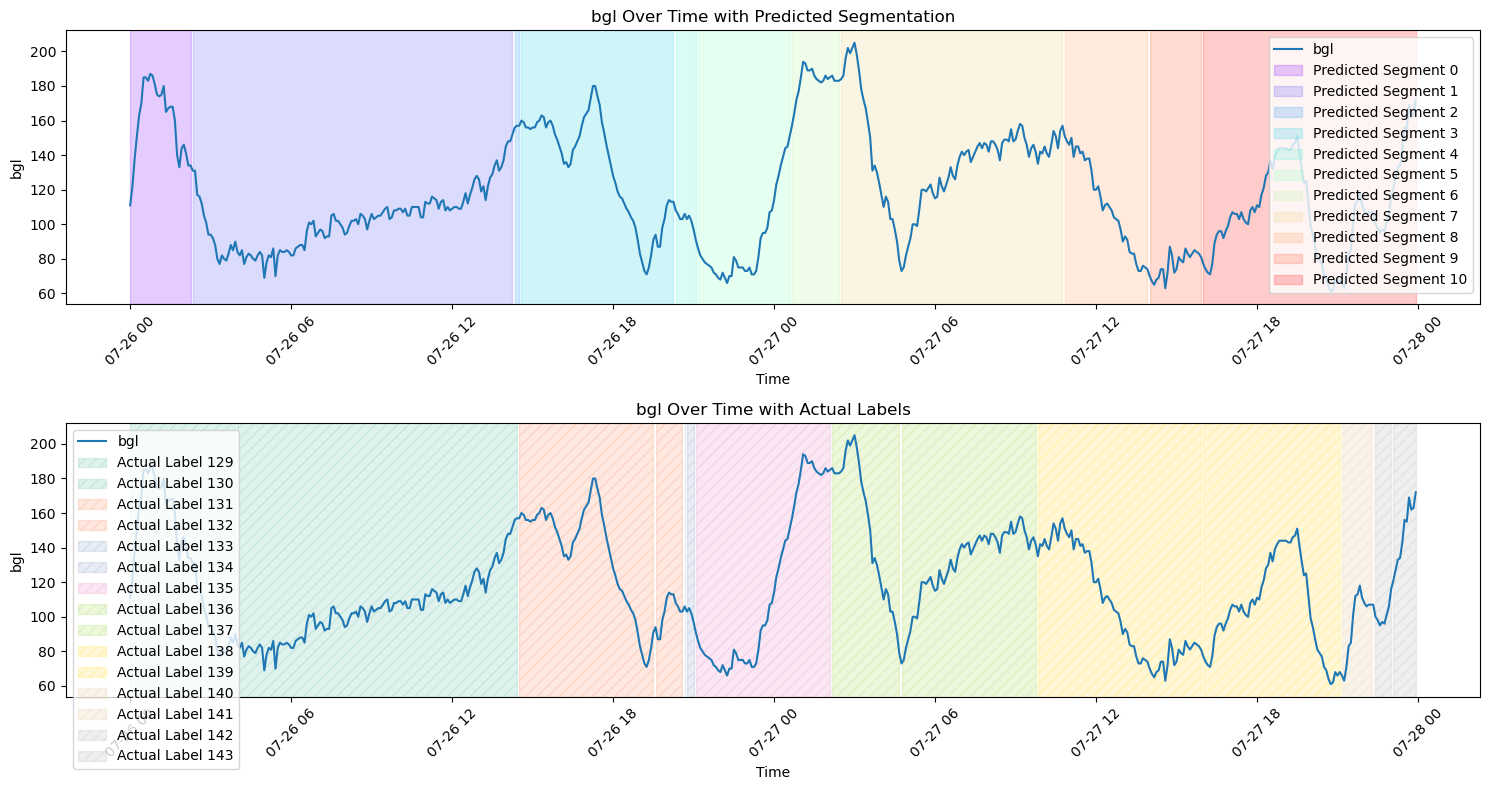

Visualizing results for Patient 500030, dataset_3


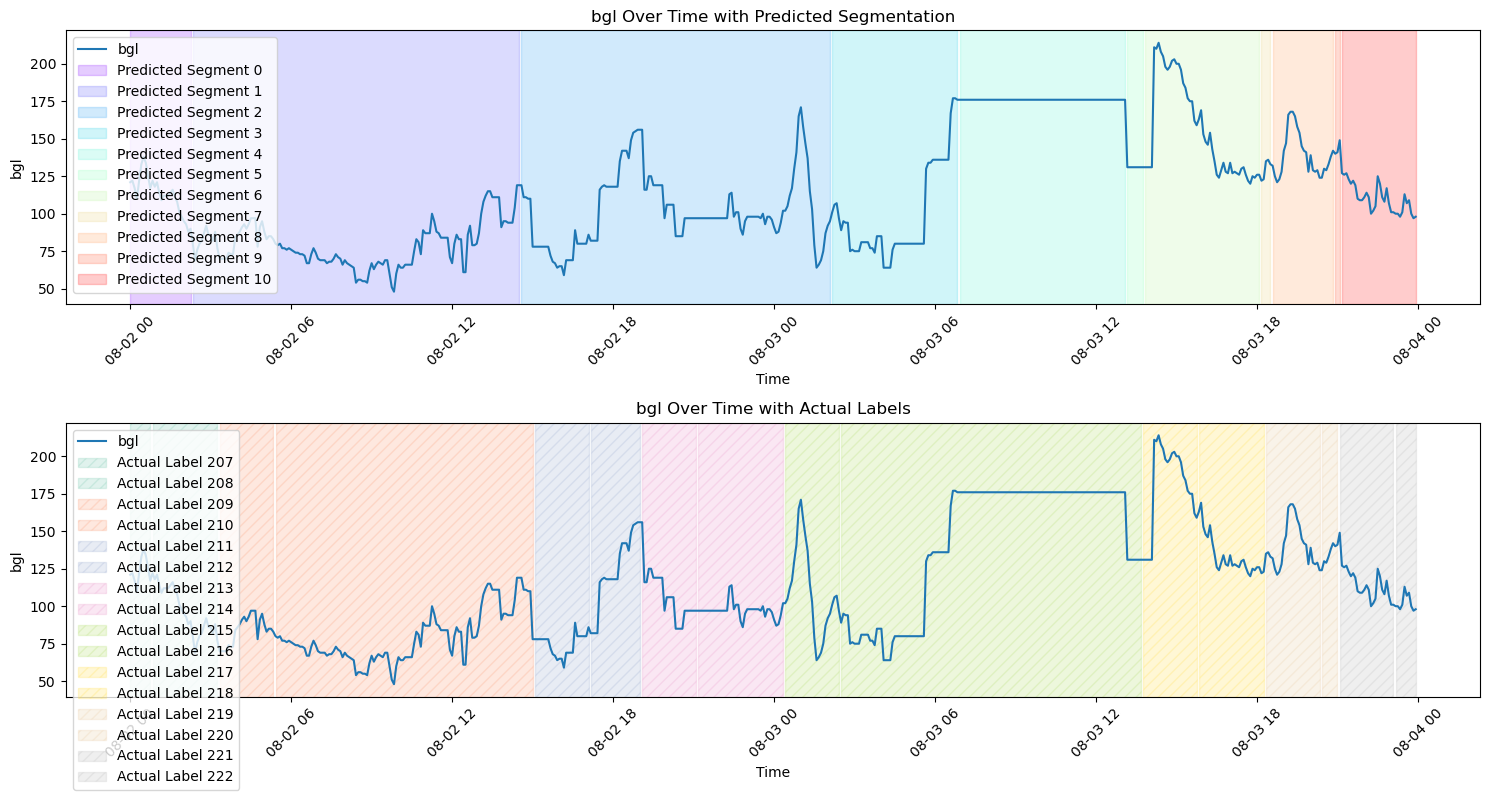

Visualizing results for Patient 500030, dataset_4


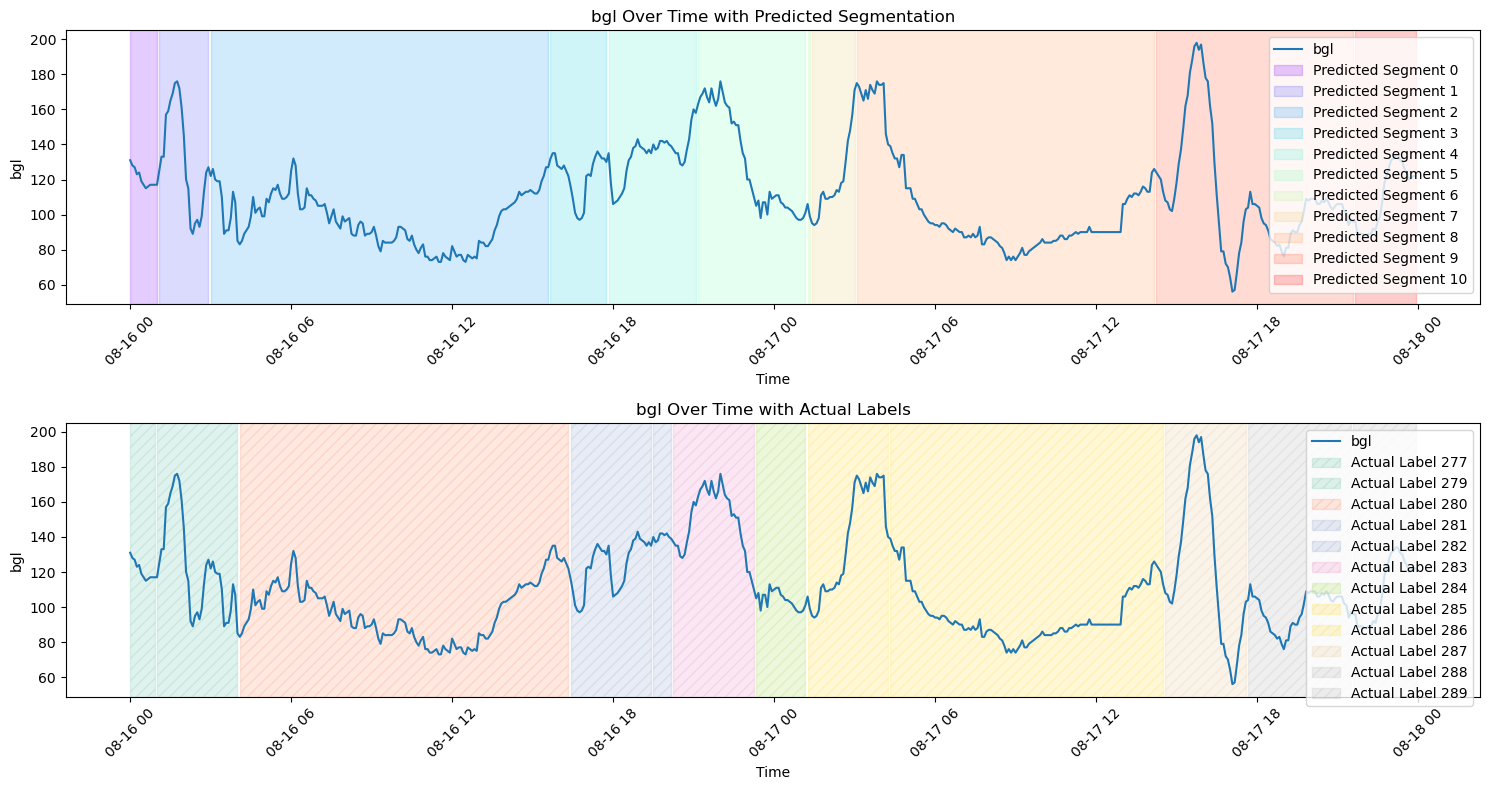

Visualizing results for Patient 500030, dataset_5


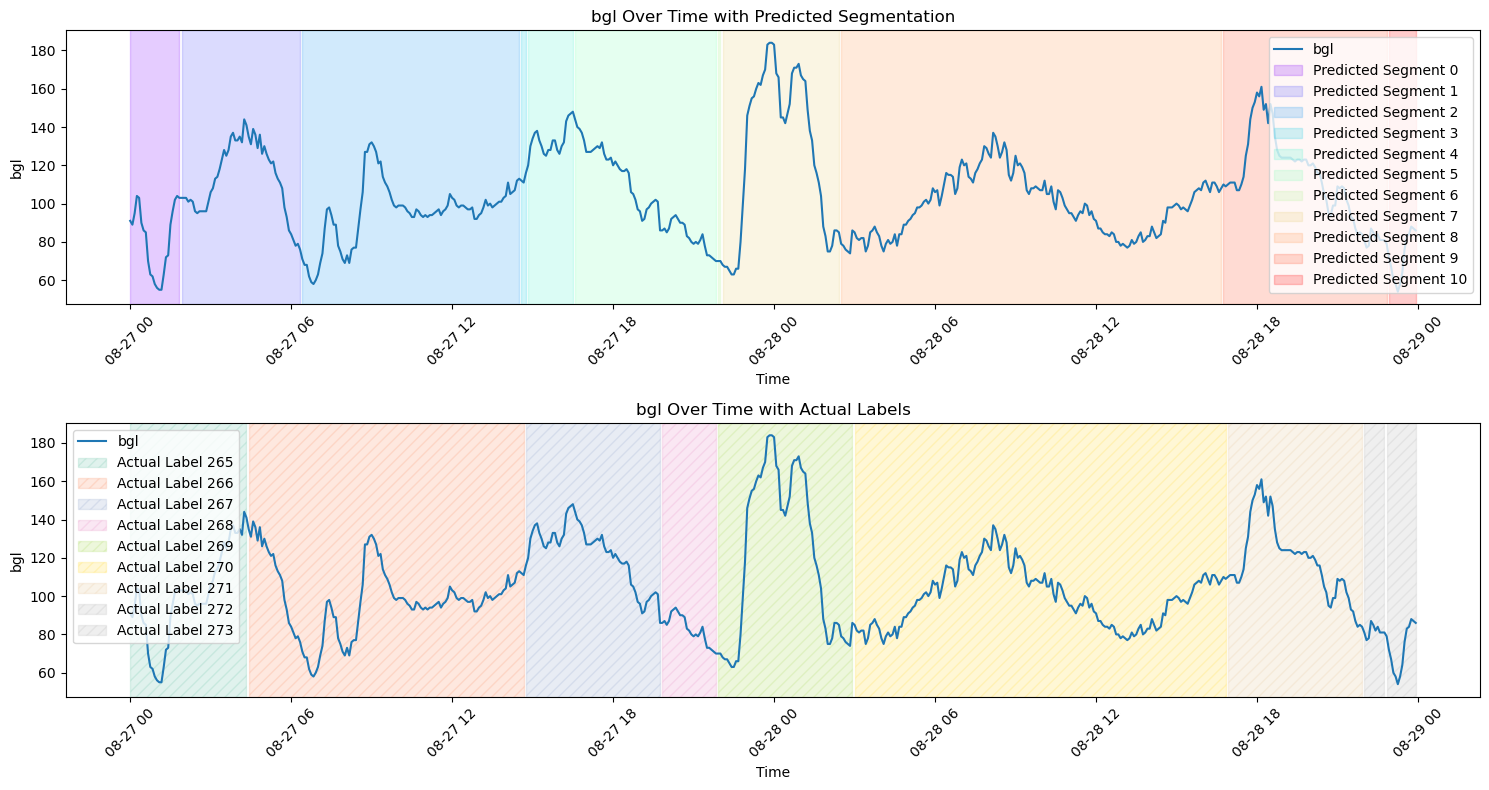

Visualizing results for Patient 679372, dataset_0


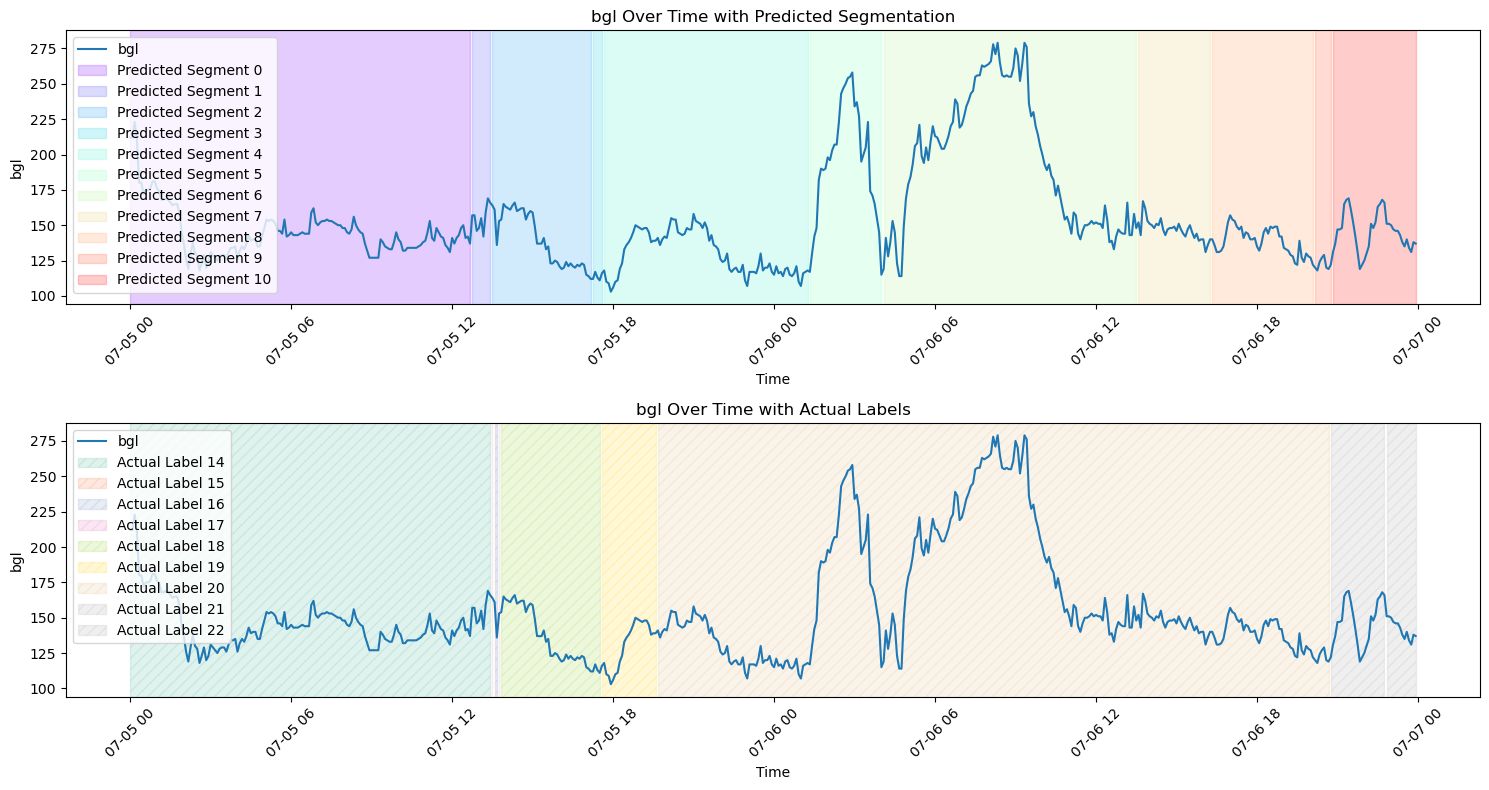

Visualizing results for Patient 679372, dataset_1


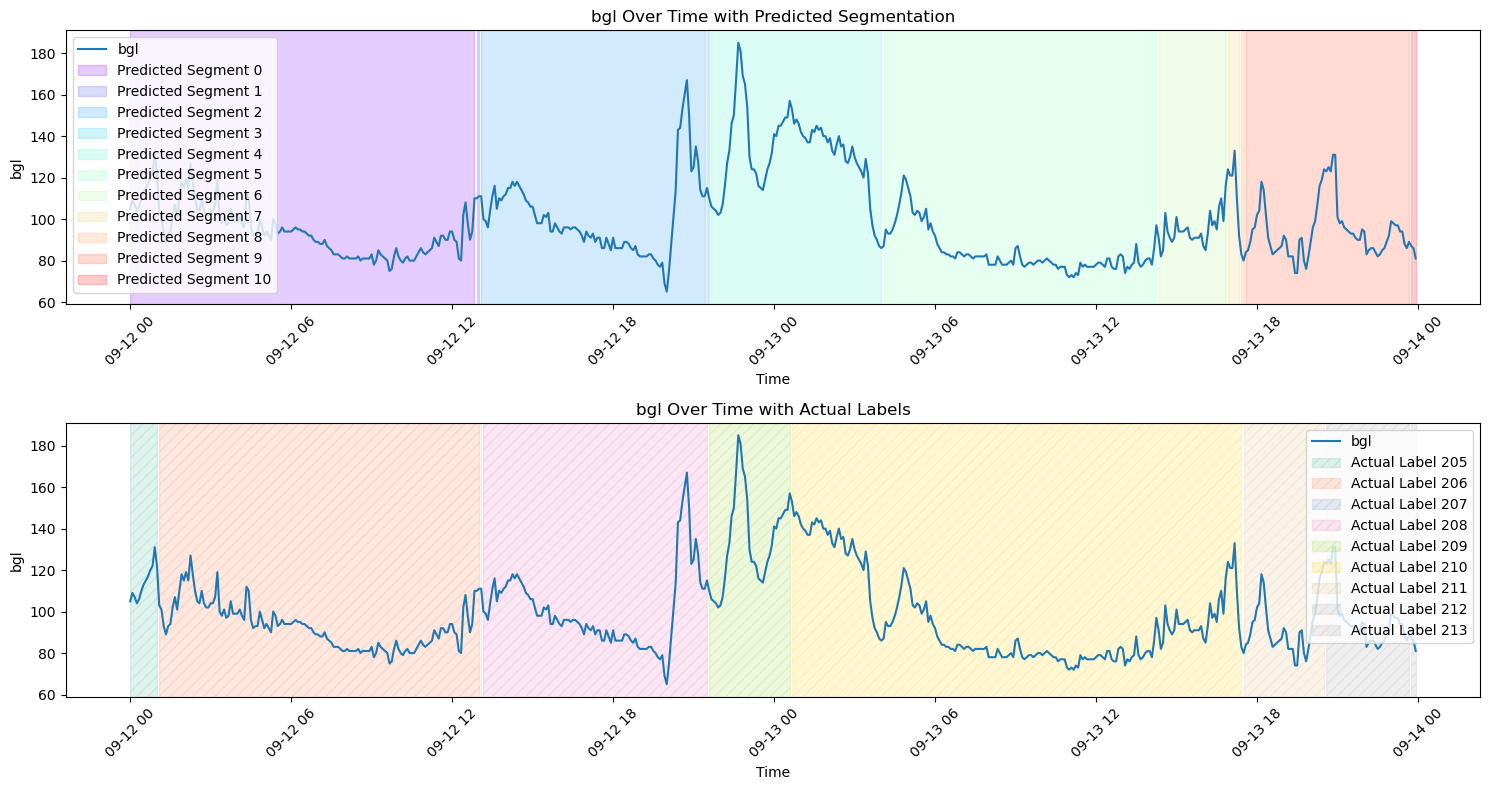

Visualizing results for Patient 679372, dataset_2


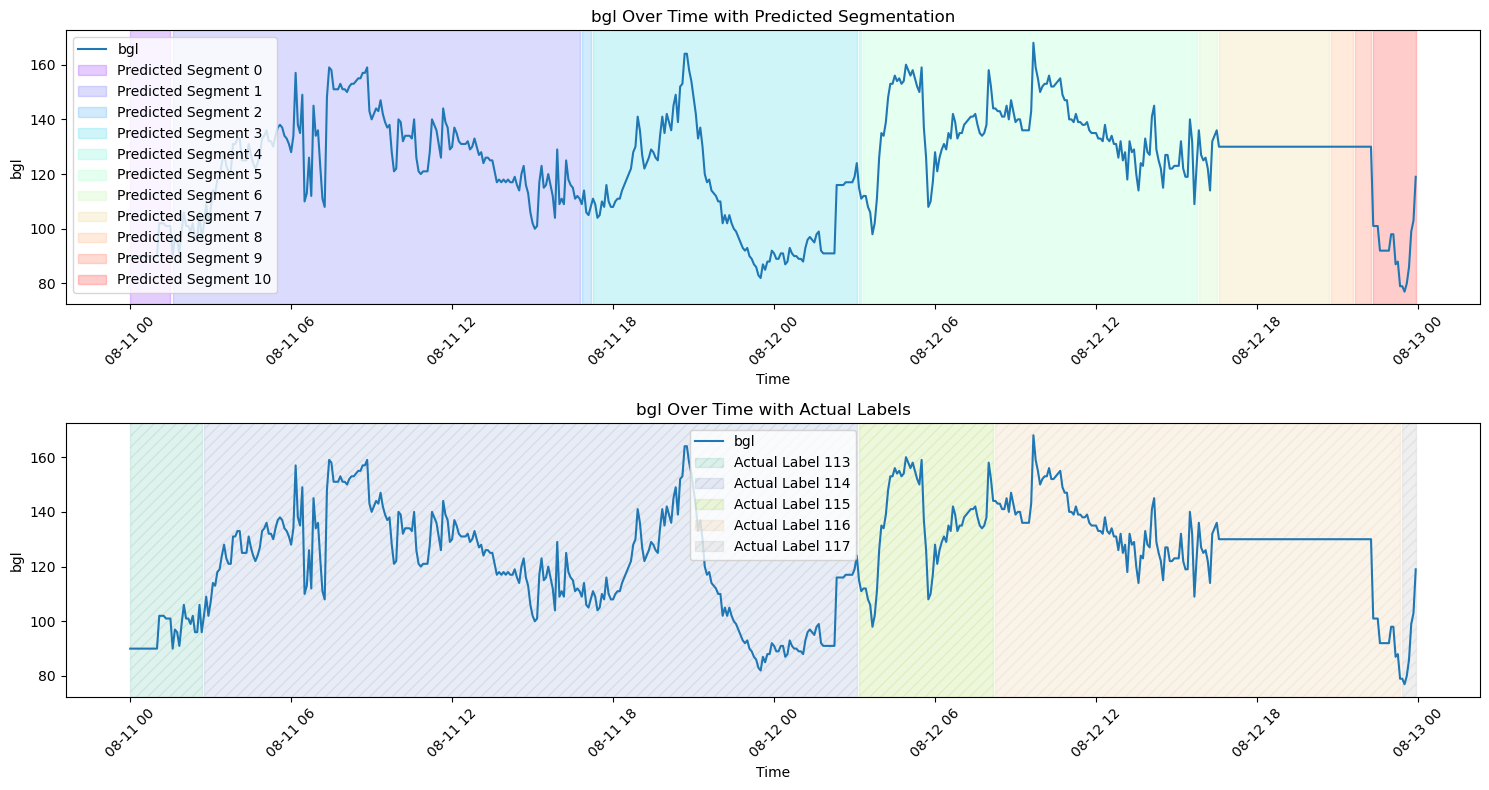

Visualizing results for Patient 679372, dataset_3


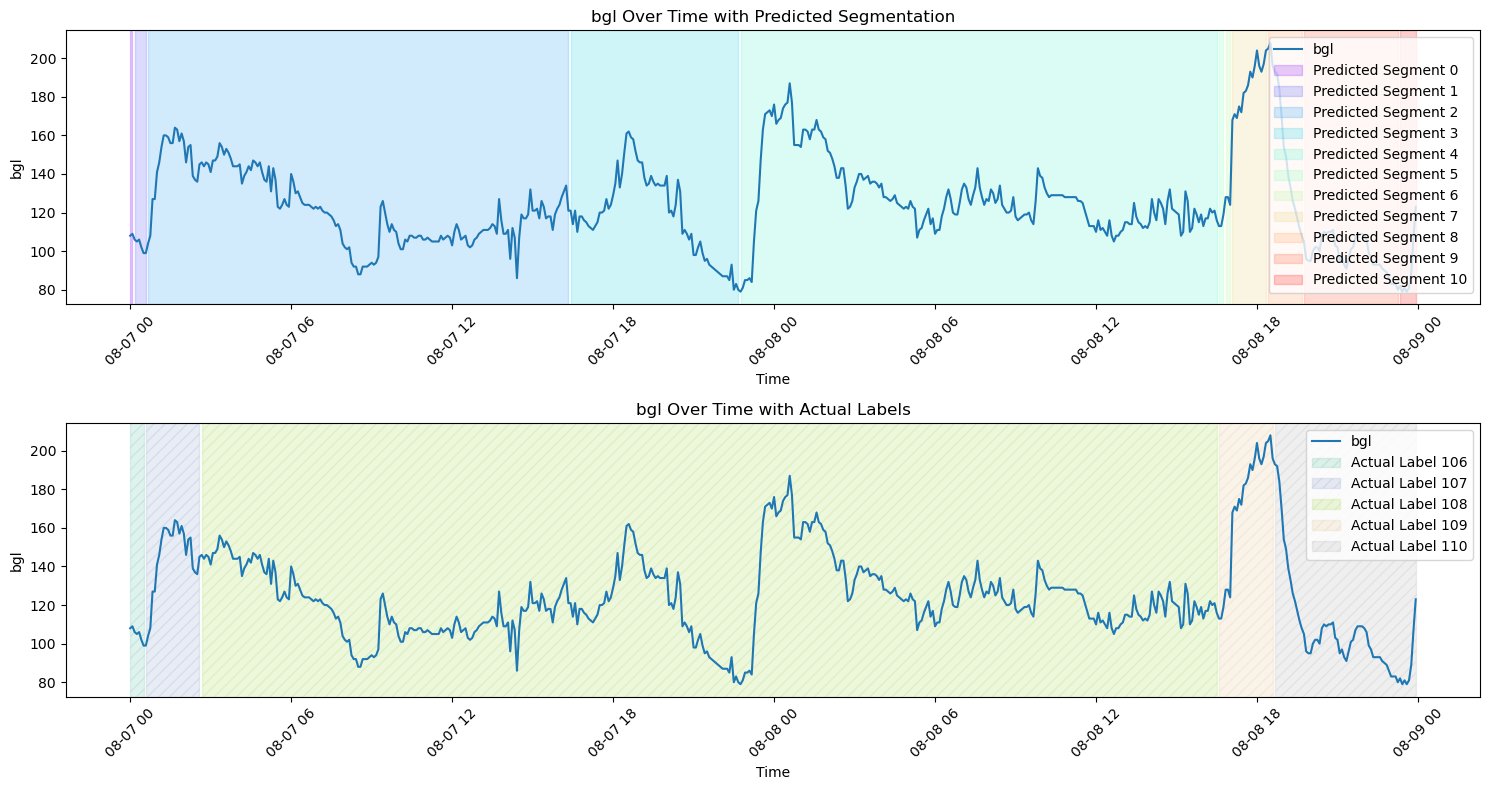

Visualizing results for Patient 679372, dataset_4


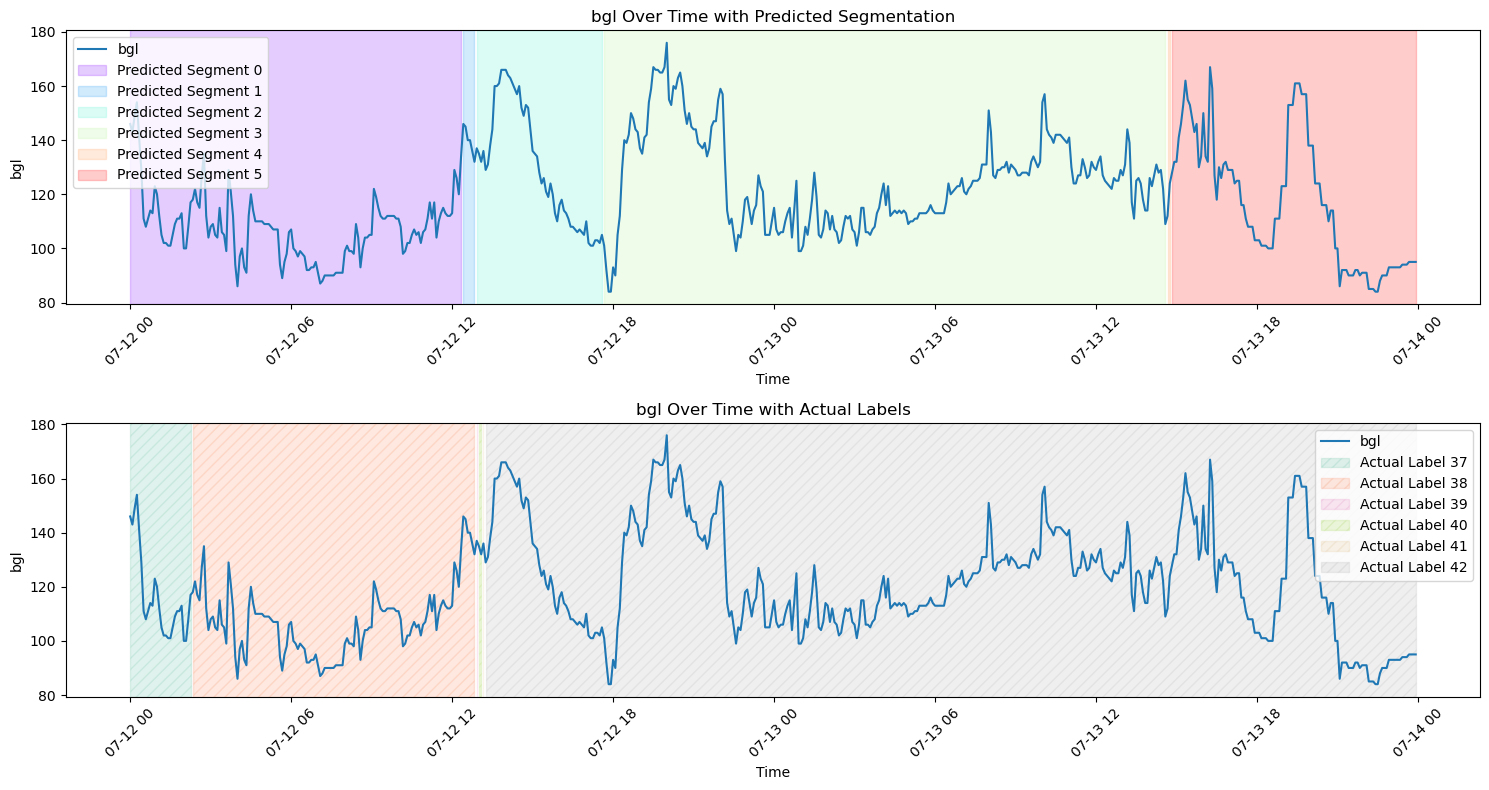

Visualizing results for Patient 679372, dataset_5


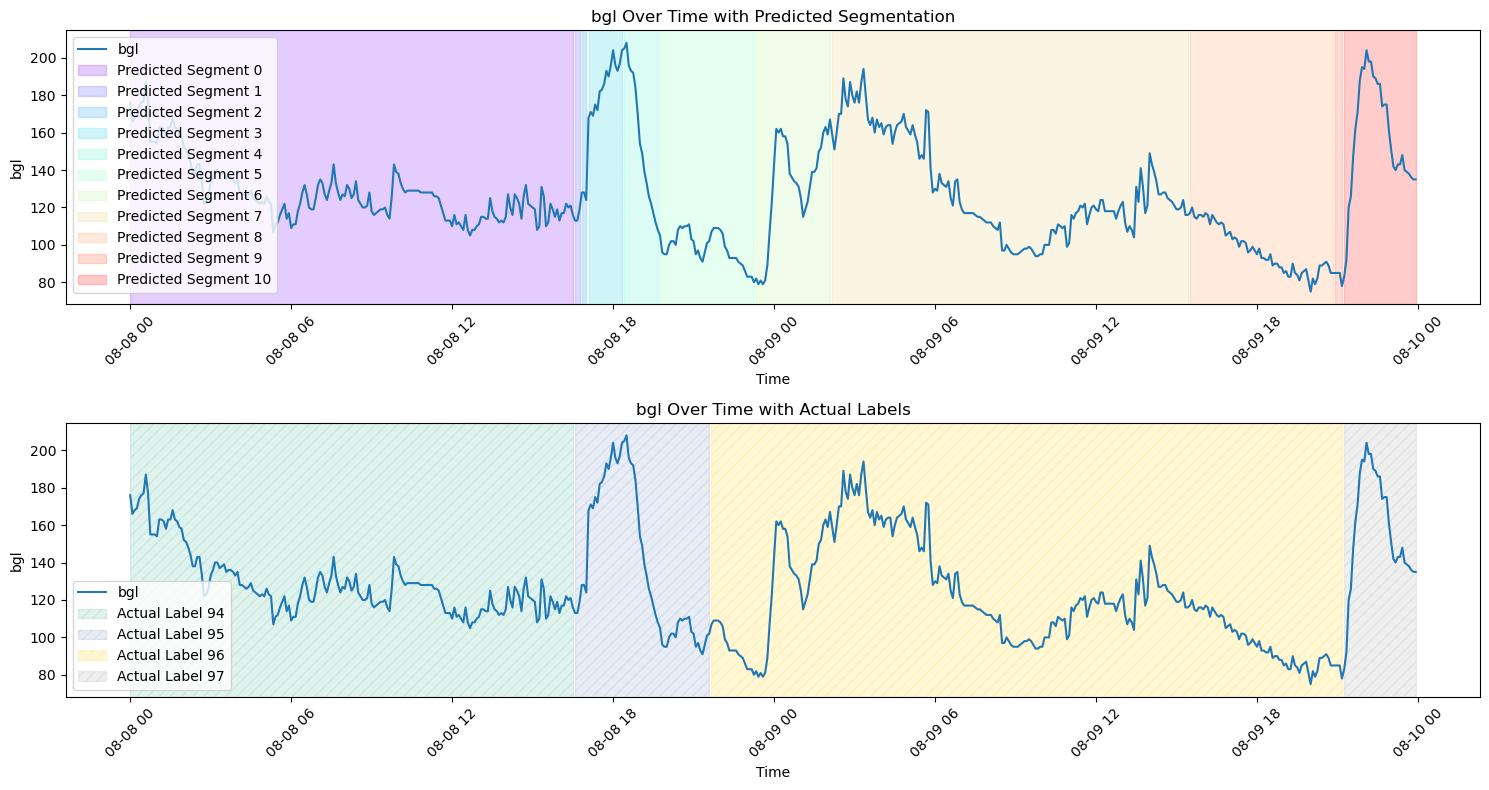

In [132]:
# Visualize results for each patient and dataset
for patient_id, patient_results in results.items():
    for dataset_key, dataset_result in patient_results.items():
        print(f"Visualizing results for Patient {patient_id}, {dataset_key}")
        X_day = dataset_result['X']
        segmentation = dataset_result['segmentation']
        actual_labels = dataset_result['actual_labels']
        
        visualize_segmentation(X_day, segmentation, actual_labels, column_name='bgl')

### Visualize supervised results
Plots the results. 
1. The first graph shows what the model predicted for its segments
2. The second graph shows the actual segments in the data

In [133]:
# Visualize the results
# Supervised GGS segmentation
visualize_segmentation(X_nested[['bgl']], supervised_segmentation, column_name='bgl')

# Labelled segmentation from the data
# Filter the meal_segment data based on the timeframe used for X_nested
start_date = X_nested.index[0]
end_date = X_nested.index[-1]
filtered_meal_segment = df.loc[start_date:end_date, 'meal_segment']

# Visualize the filtered meal segments
visualize_segmentation(X_nested[['bgl']], filtered_meal_segment, column_name='bgl')


NameError: name 'X_nested' is not defined